## PyTorch Transfer Learning

What is transfer learning? 
Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.
- Pretrained model = foundation models


In [2]:
import torch
import torchvision

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.5.1
True
12.1
90100


In [3]:
# Setup device agnositc code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data
We need our pizza, steak, sushi data to build a transfer learning model on.

In [36]:
import zipfile
import os 
from pathlib import Path
import shutil

# Setup paths
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_99"
existing_zip_path = Path("C:/Users/yashs/data/pizza_steak_sushi_99_percent.zip")  # Use raw string or forward slashes

# If the image folder doesn't exist, prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Check if the existing zip file is present
    if existing_zip_path.is_file():
        print(f"Found existing zip file at {existing_zip_path}, copying it...")
        
        # Copy the zip file to our desired data path
        destination_zip_path = data_path / "pizza_steak_sushi.zip"
        shutil.copy(existing_zip_path, destination_zip_path)
        
        # Unzip the data
        with zipfile.ZipFile(destination_zip_path, "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)
        
        # Optionally remove the copied zip file if you don't need it
        # destination_zip_path.unlink()
    else:
        print(f"Error: Could not find existing zip file at {existing_zip_path}")
        # You could add the original download code here as a fallback



Did not find data\pizza_steak_sushi_99 directory, creating one...
Found existing zip file at C:\Users\yashs\data\pizza_steak_sushi_99_percent.zip, copying it...
Unzipping pizza, steak, sushi data...


In [37]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_99/train'),
 WindowsPath('data/pizza_steak_sushi_99/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn in into PyTorch DataLoaders.
To do so, we can use `data_setup.py` and the create_dataloaders() functions.
There's one thing we have to think about when loading: how to transform it?
And with torchvision there's two ways to do this:
- 1. Manually created transforms - you define what transforms you want your data to go through
- 2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.


### 2.1 Creating a transform for torchvision.models (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within torchvision.

- All pre-trained models expect input images normalized in the same way. i.e. mini-batches of 3 channels images of shape (3 * H * W), where H and W should be atleast 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean =  [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.


In [38]:
from torchvision import transforms 
normalize = transforms.Normalize( mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [39]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=32
    
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c211873ac0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.modles (auto creation)
as of torchvision v0.13+ there is now support for automatic data transform creating based on the pretrained model weights you're using                        

In [40]:
import torchvision 
torchvision.__version__

'0.20.1'

In [41]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [42]:
# Get a transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [43]:
# Create Dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=auto_transforms,
    test_transform=auto_transforms,
    batch_size=32
    
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c21150ddb0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

- There are various to get a pretrained model, such as:
1. Pytorch domain libraries
2. Libraries like timm (torch image models)
3. HuggingFase Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)


### 3.1 Which pretrained model should you use ?

Experiment, experiment, experiment!
The whole idea of transfer learning: take an already well-performing model from a problem space and similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - How fast does it need to run?
2. Size - How big is the model?
3. Performance - How well does it go on your chosen problem (eg. How well does it classify food images? for FoodVision?)




### 3.2 Setting up a pretrained model


In [44]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [45]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3. Getting a summary of our model with torchinfo.summary()

In [46]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model an changing the output layer to suit our needs
With a feature extractor model, typically you will 'freeze' the base layers of a pretrained model and update the output layers to suit your oon problem.

In [47]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [48]:
len(class_names)

3

In [49]:
# Update the classifier head of our model to suit our problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
             out_features=len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [50]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [51]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [52]:
# Import train function
from going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer
start_time = timer()
# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device,
                      scheduler=scheduler)
# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6708 | train_acc: 0.7640 | test_loss: 0.3446 | test_acc: 0.9167 | lr: 0.001000
Epoch: 2 | train_loss: 0.3926 | train_acc: 0.8778 | test_loss: 0.2518 | test_acc: 0.9323 | lr: 0.001000
Epoch: 3 | train_loss: 0.3295 | train_acc: 0.8886 | test_loss: 0.2195 | test_acc: 0.9362 | lr: 0.001000
Epoch: 4 | train_loss: 0.2977 | train_acc: 0.8992 | test_loss: 0.1968 | test_acc: 0.9401 | lr: 0.001000
Epoch: 5 | train_loss: 0.2866 | train_acc: 0.8965 | test_loss: 0.1864 | test_acc: 0.9466 | lr: 0.000500
Epoch: 6 | train_loss: 0.2677 | train_acc: 0.9106 | test_loss: 0.1797 | test_acc: 0.9466 | lr: 0.000500
Epoch: 7 | train_loss: 0.2566 | train_acc: 0.9137 | test_loss: 0.1705 | test_acc: 0.9453 | lr: 0.000500
Epoch: 8 | train_loss: 0.2612 | train_acc: 0.9075 | test_loss: 0.1785 | test_acc: 0.9466 | lr: 0.000500
Epoch: 9 | train_loss: 0.2378 | train_acc: 0.9140 | test_loss: 0.1657 | test_acc: 0.9518 | lr: 0.000500
Epoch: 10 | train_loss: 0.2296 | train_acc: 0.9213 | test_loss: 

  0%|          | 0/10 [00:00<?, ?it/s]

## 5. Evaluate model by plotting loss curves

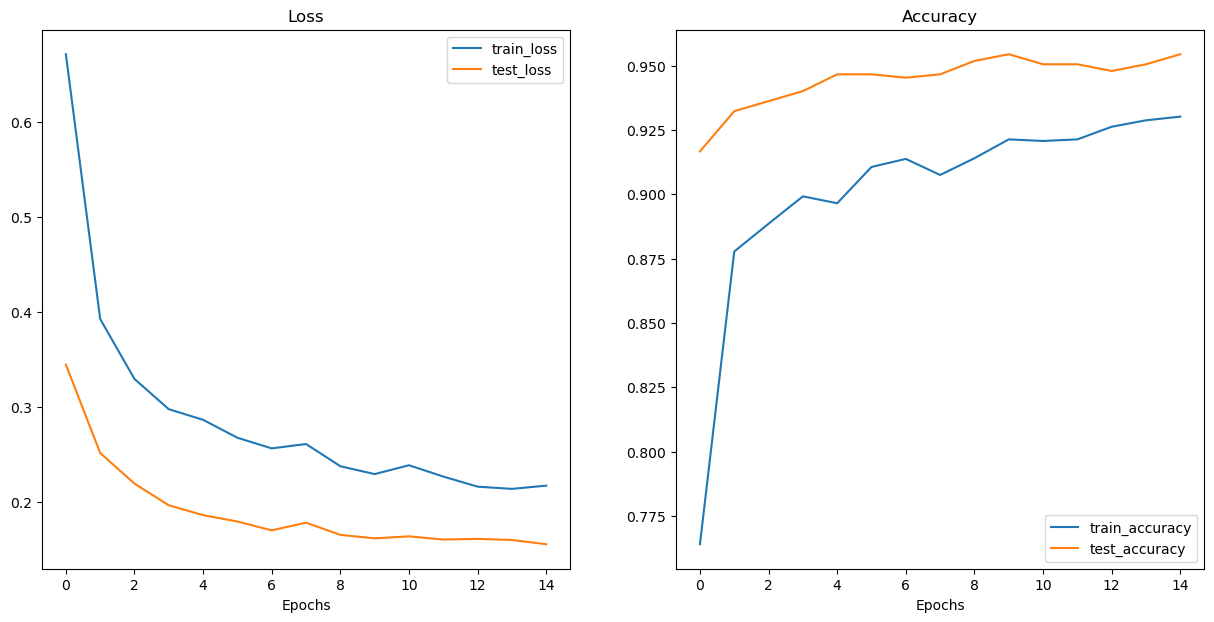

In [53]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set
Let's adhere to the data explorer's motto of visualize, visualize, visualize!

And make some qualitiative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:

- Same shape - images need to be same shape as model was trained on
- Same datatype - custom data should be in the same data type
- Same device - custom data/test data should be on the same device as the model
- Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

In [54]:
from typing import List, Tuple
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

#1. Take in a trained model..
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    # 2. Open the image with PIL
    img = Image.open(image_path)

    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

    ## Predict on image
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add and extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on the transformed image 
        target_image_pred = model(transformed_image.to(device))

    # 8.Convert the model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the model's pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img) 
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


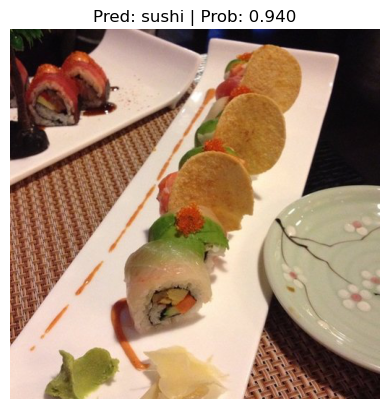

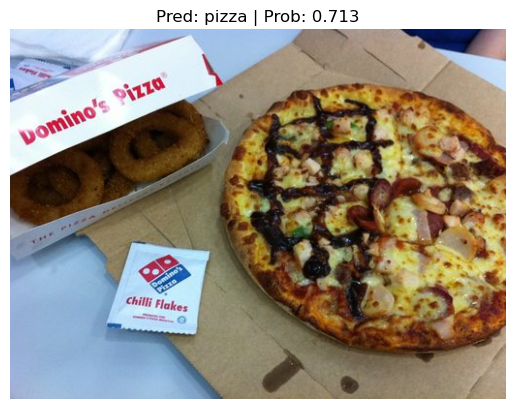

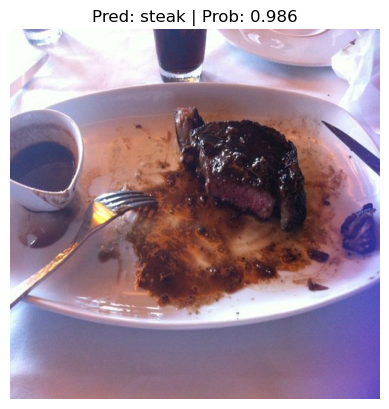

In [55]:
# Get a random list of image paths from the test set 
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 6.1 Making prediction on a custom image

In [56]:
# setup custom image path
custom_image_path = data_path / 'sushi_image2.jpeg'

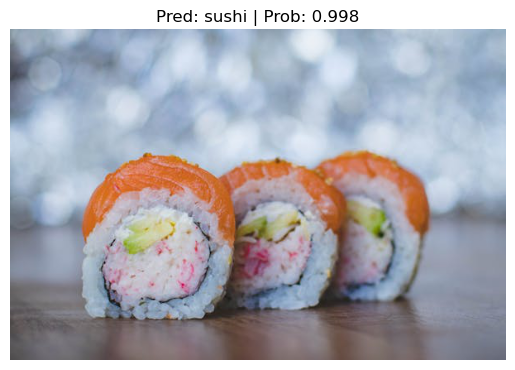

In [57]:
# Predict on custom image
pred_and_plot_image(model=model,
             image_path=custom_image_path,
             class_names=class_names)

## 7. Plot confusion matrix

In [58]:
from tqdm.auto import tqdm

# Put model in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        logits = model(X)
        preds = torch.argmax(logits, dim=1)
        
        # Append predictions and true labels
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

  0%|          | 0/24 [00:01<?, ?it/s]

In [59]:
import torchmetrics
from torchmetrics import ConfusionMatrix

# Create confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(all_preds, all_labels)

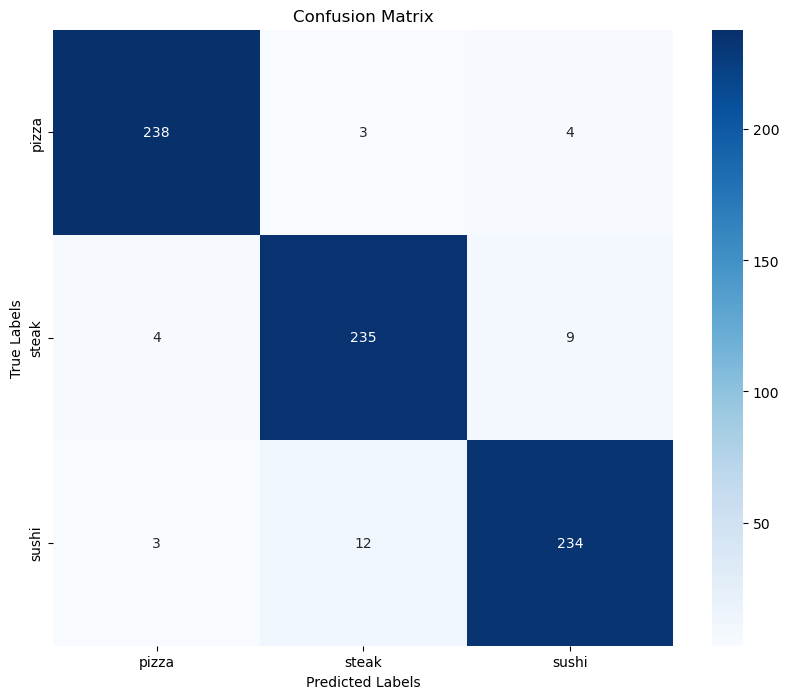

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert confusion matrix to numpy array
confmat_np = confmat_tensor.numpy()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(confmat_np,            
            annot=True, 
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## 8. Save model

In [61]:
import torch 
from pathlib import Path

def save_model(model: torch.nn.Module,
              target_dir: str,
              model_name: str):
    """Saves a PyTorch model to a target directory.
    
    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
    
    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """

    # Create target directory 
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith('.pth') or model_name.endswith('.pt'), 'model_name should end iwth .pt or .pth'
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f'[INFO] Saving model to: {model_save_path}')
    torch.save(obj=model.state_dict(),
              f=model_save_path)

In [62]:
save_model(model, 'models', 'food_03_transfer_99.pth')

[INFO] Saving model to: models\food_03_transfer_99.pth
